# Uber Fare Prediction

### Objective:
Predict the price of an Uber ride given pickup and drop-off coordinates.

### Tasks:
1. Preprocess the dataset  
2. Identify and remove outliers  
3. Check correlations among features  
4. Implement **Linear Regression** and **Random Forest Regression** models  
5. Evaluate and compare both models using RMSE and R² metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Step 1: Load the Dataset


In [2]:
df = pd.read_csv("uber.csv")
print(df.head())

   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


### Step 2: Data Cleaning and Preprocessing
Remove missing values, invalid fare amounts, and unrealistic passenger counts.

In [4]:
# Check for missing values
df.isna().sum()


Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [5]:
# Drop rows with missing values
df.dropna(inplace=True)
print("After dropping NaNs:", df.shape)

After dropping NaNs: (199999, 9)


In [6]:
# Remove invalid fare amounts (negative or zero)
df = df[df["fare_amount"] > 0]

In [7]:
# Remove invalid passenger counts
df = df[(df["passenger_count"] > 0) & (df["passenger_count"] <= 6)]

### Step 3: Outlier Detection & Removal
Visualize outliers in the `fare_amount` column using a boxplot, then remove them using the IQR (Interquartile Range)

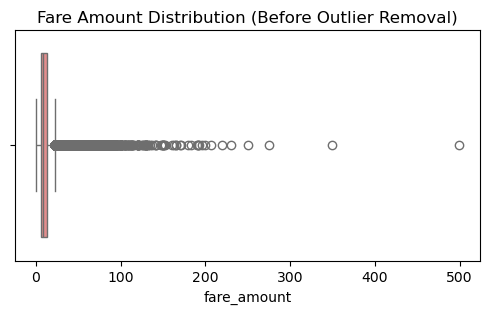

In [8]:
# Boxplot before removing outliers
plt.figure(figsize=(6, 3))
sns.boxplot(x=df["fare_amount"], color="lightcoral")
plt.title("Fare Amount Distribution (Before Outlier Removal)")
plt.show()

In [9]:
# --- Identify and remove outliers using IQR ---
Q1 = df["fare_amount"].quantile(0.25)
Q3 = df["fare_amount"].quantile(0.75)
IQR = Q3 - Q1

# Keep only data within 1.5 * IQR
df = df[
    (df["fare_amount"] >= Q1 - 1.5 * IQR)
    & (df["fare_amount"] <= Q3 + 1.5 * IQR)
]

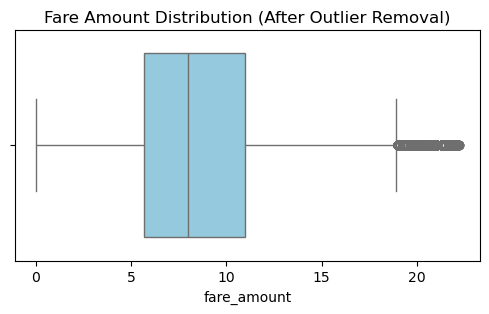

In [10]:
# Boxplot after removing outliers
plt.figure(figsize=(6, 3))
sns.boxplot(x=df["fare_amount"], color="skyblue")
plt.title("Fare Amount Distribution (After Outlier Removal)")
plt.show()

### Step 4: Feature Engineering
Compute the **distance between pickup and dropoff points** using the Haversine formula and create a new feature `distance_km`.

In [11]:
def haversine(lon1, lat1, lon2, lat2):
    """Calculate great-circle distance (km) between two points."""
    R = 6371  # Earth radius (km)
    lon1, lon2, lat1, lat2 = map(np.radians, [lon1, lon2, lat1, lat2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Compute distance and add as new column
df["distance_km"] = haversine(
    df["pickup_longitude"],
    df["pickup_latitude"],
    df["dropoff_longitude"],
    df["dropoff_latitude"],
)

# Remove entries with zero or very small distance
df = df[df["distance_km"] > 0.1]

In [12]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683323
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457590
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.036377
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.661683
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4.475450


### Step 5: Correlation Analysis
Check the correlation between `fare_amount`, `distance_km`, and `passenger_count` to understand which features influence the target variable.

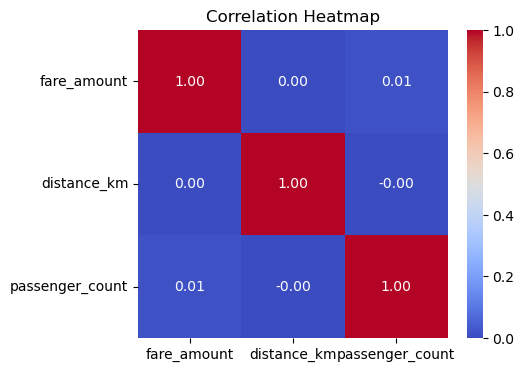

In [13]:
corr_matrix = df[["fare_amount", "distance_km", "passenger_count"]].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Step 6: Train Regression Models
Train two regression models:
- **Linear Regression**
- **Random Forest Regressor**

Then compare their performance.


In [14]:
# Features and target
X = df[["distance_km", "passenger_count"]]
y = df["fare_amount"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [15]:
# ---- Linear Regression ----
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [16]:
# ---- Random Forest Regression ----
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

### Step 7: Model Evaluation
Evaluate both models using **RMSE (Root Mean Squared Error)** and **R² (Coefficient of Determination)**.


In [17]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse_lr, r2_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")
rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")

In [18]:
comparison = pd.DataFrame(
    {
        "Model": ["Linear Regression", "Random Forest"],
        "RMSE": [rmse_lr, rmse_rf],
        "R² Score": [r2_lr, r2_rf],
    }
)
print("\nModel Comparison:")
print(comparison)


Model Comparison:
               Model      RMSE  R² Score
0  Linear Regression  4.119054  0.000080
1      Random Forest  2.665153  0.581385
